## DSCI 100 Group Project 

By Tony Fu, Hao Jiang, and Aimee Garcia Castro

## Introduction: 

There are many elements that play a role in how well a student will perform on a test. The objective for this group project is predicting the knowledge level of an individual based on such elements. The knowledge levels include: `high`, `middle`, `low` and `very_low` We will be looking at the "User Knowledge" dataset obtained from the UCI Machine Learning Repository. The data in this dataset looks at `STG` (the degree of study time for goal object materials), `SCG` (the degree of repetition number of user for goal object materials), `STR` (the degree of study time of user for related objects with goal object), `LPR` (the exam performance of user for related object with goal object), and `PEG` (the exam performance of user for goal objects). As well, it relates `PEG` to `UNS` (the knowledge level of the user). This data will be used as predictors for `UNS`
 
Our predictive question that we will try to answer is: “Can we predict the `UNS` of an individual based on factors such as `STG`, `SCG`, and `STR`?”
 


## Methods: 

We begin by loading the libraries required to perform exploratory analysis. 

In [2]:
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
library(GGally)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now, we need to transfer the data from the website to R, since the data is located on the website. As the data is available as an Excel spreadsheet, we are going to need to download it as a file with `download.file`. We have stored the file described as an url from the Internet as an object called `url` and used this in the `download.file` function.

After we have downloaded the data as a file on R, we are going to use the `read_excel` function to transfer the data from the spreadsheet. We will be using the `sheet` function to specify which sheet of the Excel file contains the data we are going to use. This will be `sheet = 2` as the second sheet is listed as **training data**, which will be crucial once we create our classifier. 

We notice that the last 3 columns are irrelevant to the data, so we will be removing those by selecting the wanted data with the `select` function.

Furthermore, although not required, we chose to lowercase all the `UNS` labels to keep the labeling consistent with the `mutate` function, along with the `recode` function.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

user_knowledge <- read_excel(path = "data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = recode(UNS, High = 'high', Middle = 'middle', Low = 'low'))

user_knowledge

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 1*: Tidied "User Knowledge" dataset obtained from UCI Machine Learning Repository

## Searching for NAs:


We will now be looking for NA values in our data frame, and handle them appropriately as they represent a missing or incomplete value in our data. 

In [4]:
sum(is.na(user_knowledge))

[1] 0

Thankfully there is no NAs in our data frame, so no necessary adjustments must be made to our current data frame.

## Defining Variables:

We have already mentioned what each of the variables acronym means in the introduction. However, to reiterate, `STG` represents the study time for main topics, `SCG` represents the reptition in studying, `STR` represents study time for related topics, `LPR` represents exam performance of related topics, `PEG` represents exam performance of main topics, and `UNS` represents the knowledge level. All variables from `STG` to `PEG` have a range from 0 to 1. `UNS` contain the labels `very_low`, `low`, `middle`, and `high`, where `very_low` corresponds to a low `PEG` whereas `high` corresponds to a high `PEG`.

## Determining Predictors:

To begin, we have decided to remove `LPR` since a high `LPR` would result from a high `STR`. This means that if we included both as predictors, we would essentially be using the same predictor twice, leading to these `STR` having a larger influence than wanted. Furthermore, we have also decided to remove `PEG` since `UNS` is based on `PEG`. 

In [5]:
user_knowledge <- user_knowledge %>%
    select(-LPR, -PEG)

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 2*: Potential predictors that may be used for analysis

Now, we are left with four variables: `STG`, `SCG`, `STR`, and `UNS`. Since the categorical class we are trying to predict `UNS`, we must turn it into a factor. This is done by using the `mutate` and `as_factor` functions.

In [6]:
user_knowledge <- user_knowledge %>%
    mutate(UNS = as.factor(UNS))

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 3*: Potential predictors with `UNS` changed to class "factor"

Currently, we need to see which predictors we should use and which ones should be removed. We will do this through a method called forward selection, where we are building a model by adding one predictor at a time. This model will select the most accurate combinations given the predictors STG, SCG, and STR. We have also used the `set.seed` function to make sure our findings for accuracy are reproducable. 

In [7]:
set.seed(1)

names <- colnames(user_knowledge %>% select(-UNS)) 
example_formula <- paste("UNS", "~", paste(names, collapse="+"))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        user_knowledge_recipe <- recipe(as.formula(model_string), 
                                data = user_knowledge) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
        acc <- workflow() %>%
          add_recipe(user_knowledge_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ STG,0.5001508
2,UNS ~ STG+STR,0.4033183
3,UNS ~ STG+STR+SCG,0.3917044


*Table 4*: Accuracies of different number of predictors used in the model

As we can see in the table, the most accurate predictor is `STG`. The second most would be `STR`, since the model selected the combination of `STG` and `STR` as the most accurate when using two predictors. Finally, `SCG` would be the least accurate predictor out of the three. We can also see that there is a constant decrease when we add predictors. With this information, we have decided to use `STG` and `STR` as the predictors in our analysis since we require at least two predictors and it has been shown that these two are the most accurate in combination. Thus, we can remove `SCG` from our data frame.

In [8]:
user_knowledge <- user_knowledge %>%
    select(-SCG)

user_knowledge

STG,STR,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.08,0.10,high
0.06,0.05,low
⋮,⋮,⋮
0.54,0.71,high
0.50,0.81,middle
0.66,0.76,high


*Table 5*: Predictors that will be used for analysis

## Exploratory Analysis:

To start, we will perform some exploratory analysis on our predictors `STG` and `STR` and see their relationship with our categorial variable of interest `UNS`. We will create some historgrams showing the distribution of both `STG` and `STR` and also colour by income. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



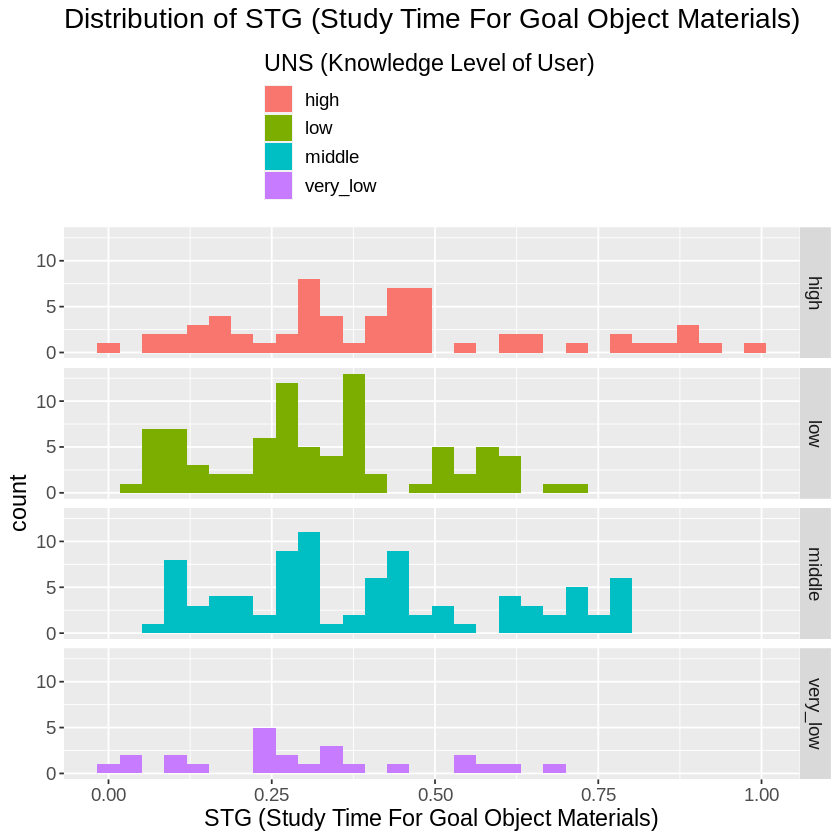

In [46]:
user_knowledge_plot <- ggplot(user_knowledge, aes(x = STG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    labs(x = "STG (Study Time For Goal Object Materials)", fill = "UNS (Knowledge Level of User)") +
    ggtitle("Distribution of STG (Study Time For Goal Object Materials)") + 
    theme(text = element_text(size = 14), 
    legend.position = "top",
        legend.direction = "vertical")

user_knowledge_plot

*Figure 1*: Distribution of `STG colored by `UNS`

Looking at Figure 1, we can see that 